In [4]:
# =====================================================
# Face Mask Detection using CNN (MobileNetV2)
# Dataset: With Mask / Without Mask
# Platform: Kaggle Notebook
# =====================================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.19.0


In [5]:
# Paths to dataset folders

with_mask_path = "/kaggle/input/face-mask-dataset-with-and-without-mask/facemask-dataset/dataset/with_mask"
without_mask_path = "/kaggle/input/face-mask-dataset-with-and-without-mask/facemask-dataset/dataset/without_mask"

print("With Mask Path:", with_mask_path)
print("Without Mask Path:", without_mask_path)

With Mask Path: /kaggle/input/face-mask-dataset-with-and-without-mask/facemask-dataset/dataset/with_mask
Without Mask Path: /kaggle/input/face-mask-dataset-with-and-without-mask/facemask-dataset/dataset/without_mask


In [24]:
# Image size
IMG_SIZE = 224

data = []
labels = []

# =========================
# Load images with mask
# =========================

for img_name in os.listdir(with_mask_path):

    img_path = os.path.join(with_mask_path, img_name)

    image = cv2.imread(img_path)

    if image is None:
        continue

    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0

    data.append(image)
    labels.append(1)   # Mask


# =========================
# Load images without mask
# =========================

for img_name in os.listdir(without_mask_path):

    img_path = os.path.join(without_mask_path, img_name)

    image = cv2.imread(img_path)

    if image is None:
        continue

    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0

    data.append(image)
    labels.append(0)   # No Mask


# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)

print("Total images loaded:", len(data))

Total images loaded: 3833


In [25]:
# convert labels to catogorical 
labels = to_categorical(labels, num_classes=2)

In [26]:
# First split: Train (70%) and Temp (30%)

X_train, X_temp, y_train, y_temp = train_test_split(
    data,
    labels,
    test_size=0.30,
    random_state=42,
    stratify=labels
)

# Second split: Validation (15%) and Test (15%)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=42
)

print("Training samples:", len(X_train))
print("Validation samples:", len(X_val))
print("Test samples:", len(X_test))

Training samples: 2683
Validation samples: 575
Test samples: 575


In [27]:
# Load pretrained MobileNetV2 model
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

# Freeze pretrained layers
for layer in base_model.layers:
    layer.trainable = False

I0000 00:00:1771990424.849161      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771990424.855091      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
#Add Custom Classification Layers

x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dense(128, activation="relu")(x)

x = Dropout(0.5)(x)

output = Dense(2, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [29]:
# training 

EPOCHS = 10
BATCH_SIZE = 32

history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val)
)

Epoch 1/10


I0000 00:00:1771990478.286225     101 service.cc:152] XLA service 0x7b15ec111f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771990478.286266     101 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1771990478.286270     101 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1771990479.303420     101 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-25 03:34:47.304414: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-25 03:34:47.441518: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1771990489.666480     101 device_co

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7167 - loss: 0.5719

2026-02-25 03:35:00.345374: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-25 03:35:00.482360: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7181 - loss: 0.5694

2026-02-25 03:35:16.378793: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-25 03:35:16.515377: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


84/84 ━━━━━━━━━━━━━━━━━━━━ 45s 342ms/step - accuracy: 0.7194 - loss: 0.5671 - val_accuracy: 0.9670 - val_loss: 0.1226
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9464 - loss: 0.1403 - val_accuracy: 0.9774 - val_loss: 0.0789
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9626 - loss: 0.1024 - val_accuracy: 0.9826 - val_loss: 0.0651
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9645 - loss: 0.0922 - val_accuracy: 0.9826 - val_loss: 0.0566
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9803 - loss: 0.0590 - val_accuracy: 0.9826 - val_loss: 0.0519
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9821 - loss: 0.0518 - val_accuracy: 0.9809 - val_loss: 0.0476
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9891 - loss: 0.0381 - val_accuracy: 0.9826 - val_loss: 0.0444
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9876 - loss: 0.0386 - val_accuracy: 0.9843 - val_loss: 

In [30]:
# evaluation

test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Test Accuracy:", test_accuracy)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9877 - loss: 0.0325
Test Accuracy: 0.9878261089324951


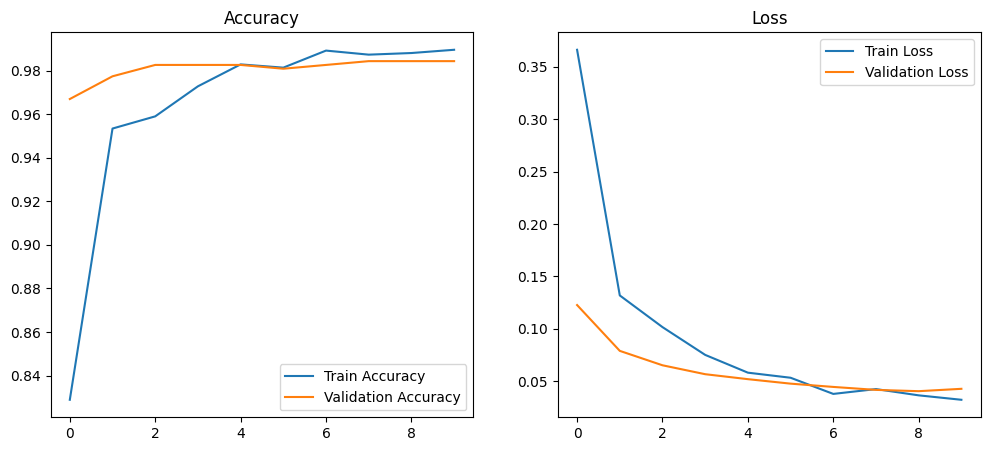

In [31]:
# plot training performance
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss")

plt.show()

In [32]:

# classification report
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = np.argmax(y_test, axis=1)

print(classification_report(true_classes, predicted_classes))

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       294
           1       0.98      0.99      0.99       281

    accuracy                           0.99       575
   macro avg       0.99      0.99      0.99       575
weighted avg       0.99      0.99      0.99       575



In [34]:
model.save("face_mask_detector_model.h5")

print("Model saved successfully.")

Model saved successfully.
